In Aristophanes's *Clouds*, we find a certain Strepsiades who joins a philosophy-rhetoric school—The Phrontisterion—in order to learn the arts of Strong and Weak Argumentation from Socrates in the hopes of getting out of financial straits. For our purposes, we don't need to concern ourselves as much with the plot as with the main characters and main ideas of the comedy. Or to put in in terms of an earlier experiment, we want to find the *key* words of *Clouds*, that is that words that refer to the characters, places, ideas, and so on that are specifically important to this play and so to, say, other plays of Aristophanes like *Lysistrata* or *The Frogs*. Our plan then in this experiment based on a chapter from the upcoming book *Exploratory Philology* is to generate a word cloud, a *Clouds* cloud if you will.

Wordclouds are a text visualization that packs words densely into a confined space such that the words themselves are given visual priority—e.g. some words will be bigger than others—based on some criteria and often specifically based on frequency. As @hicke_word_2022 notes: "Their intuitive and engaging design has made them a popular choice for authors, but many visualization specialists are skeptical about their effectiveness." Nevertheless, as @kalanicraig_teaching_2014 writes, the format can show students a "systematic way to handle something many of them think of as ineffable" and specifically one that can 
"appeal to humanities students a way of questioning their intuitive approach to textual analysis."

Before getting into the code, let's sketch out a plan for the experiment in pseudocode, i.e. some plain-language instructions that we can "translate" into working Python. Let's start with the following...

1. Load the text of Aristophanes' *Clouds* and preprocess the text and create a Counter object with word frequencies. This will get us the data we need to create the wordcloud and give us a sense of what we should expect to see there.
2. Import the `wordcloud` package and use it to create a word cloud from the Counter object.

The thing is that we'll quickly realize that a wordcloud of just the most frequent words isn't very interesting. So we'll add a few more steps to get the *key* words in the text. We already know from previous experiments that kai and de and so on are going to be the most frequent words. But we also know that καί and δέ and de are not the main characters, so to speak, if *Clouds*. Our visualization should the literal main character like Socrates in big type. The Phronisterion is central to the action of *Clouds* but doesn't appear in the other plays—it should call attention to itself in the mass of words. This play is about thinking and learning. The cloud should reflect this. So, we push the experiment one step further...

3. Compute tf-idf scores for each word in all of the plays of Aristophanes.
4. Create a word cloud based on the key words from *Clouds* (in comparison with the other plays).

In [125]:
# Imports

from cltkreaders.grc import GreekTesseraeCorpusReader
from eptools import preprocess

from collections import Counter

from tabulate import tabulate
from pprint import pprint

import matplotlib.pyplot as plt

We'll use CLTK Readers to get the text of Aristophanes' *Clouds* into memory and preprocess it in a way that is easier to visualize in a wordcloud, specifically we will lowercase the text and remove diacritics such as breathings and accents.

In [141]:
# Pseudocode 1a: "Load the text of Aristophanes' *Clouds*..."

CR = GreekTesseraeCorpusReader()

file = [file for file in CR.fileids() if 'clouds' in file][0]
print(file)

aristophanes.clouds.tess


In [127]:
# Print sample from text

text = next(CR.texts(file))
print(text[:106])

ἰοὺ ἰού:
ὦ Ζεῦ βασιλεῦ τὸ χρῆμα τῶν νυκτῶν ὅσον:
ἀπέραντον. οὐδέποθ' ἡμέρα γενήσεται;


In [128]:
# Pseudocode 1b: "preprocess the text..."

text = preprocess(text, diacriticals=False)
print(text[:84])

ιου ιου 
ω ζευ βασιλευ το χρημα των νυκτων οσον 
απεραντον ουδεποθ ημερα γενησεται 



Before making the wordcloud, let's get a preliminary sense of which words are most frequent in the *Clouds*, especially since, without any further processing, the words that we should expect to see in the wordcloud are going to be these very words. A century ago, to get sense of word frequency you might look to a concordance like @dunbar_complete_1883. With the digitized text, we can count words directly from the textual data using `Counter` from the `collections` module...

In [129]:
# Pseudocode 1c: "... and create a Counter object with word frequencies."

wordcount = Counter(text.split())
print(tabulate(wordcount.most_common(10), headers=['Word', 'Count']))

Word      Count
------  -------
και         276
τι          170
τον         153
γαρ         106
την         104
αλλ         101
ω            90
δ            85
αν           84
των          71


This list gives us a nice tabular view of the most frequent words in the text, but how can we get a better sense of the relative frequency of different words (and do it with a fully graphical representation)? For this, we turn to the wordcloud...

In [130]:
#Pseudocode 2: Import the `wordcloud` package and use it to create a word cloud from the Counter object.

from wordcloud import WordCloud
wordcloud = WordCloud(regexp=r'\b[^\W\d_]+\b').generate(text)

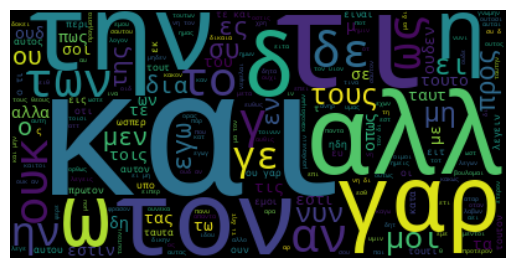

In [131]:
# Display the wordcloud

plt.imshow(wordcloud, interpolation='bilinear');
plt.axis("off");

We can adjust the parameters, spec. the `max_font_size` parameter in the `WordCloud` class to cram even more words into the same space.

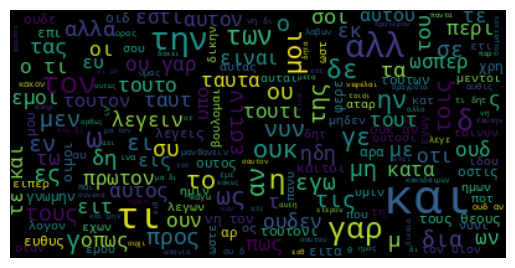

In [132]:
# Display the wordcloud, with lower `max_font_size`

wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at this frequency-based wordcloud, we see exactly the words we expected to see based on the Counter from above: και, τι, τον, γαρ, την, αλλ, ω, δ, αν, των. All important, of course, but carrying no signature of *Clouds*. It could be any play of Aristophanes, any work on Ancient Greek.

Luckily we have ways of getting key terms based on a collection of documents, for example tf-idf. A full discussion of tf-idf—or term frequency-inverse document frequency—is out-of-scope for this blog post (though I do have a full tf-idf blog-post explainer coming soon!). For now, let's take the basic [Wikipedia definition](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) as our starting point:  we are talking about a "measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general." The word for "clouds" appears more often *Clouds* than in the other Aristophanic works. Ditto "frogs" and *Frogs*. And the ways in which some words appear not merely frequently throughout a collection of documents but within specific documents (and not other!) can be measured using tf-idf. 

Let's use the approach here, using all of the plays of Aristophanes as ground to *Clouds* figure.

In [133]:
# Get all of the files of Aristophanes' plays

files = [file for file in CR.fileids() if 'aristophanes.' in file]
pprint(files)
print()

# Make labels based on the files
labels = [file.split('.')[1] for file in files]
pprint(labels)
print()

texts = [preprocess(next(CR.texts(file)), diacriticals=False) for file in files]
print(f'There are {len(texts)} texts in this collection.')

['aristophanes.acharnians.tess',
 'aristophanes.birds.tess',
 'aristophanes.clouds.tess',
 'aristophanes.ecclesiazusae.tess',
 'aristophanes.frogs.tess',
 'aristophanes.knights.tess',
 'aristophanes.lysistrata.tess',
 'aristophanes.peace.tess',
 'aristophanes.plutus.tess',
 'aristophanes.thesmophoriazusae.tess',
 'aristophanes.wasps.tess']

['acharnians',
 'birds',
 'clouds',
 'ecclesiazusae',
 'frogs',
 'knights',
 'lysistrata',
 'peace',
 'plutus',
 'thesmophoriazusae',
 'wasps']

There are 11 texts in this collection.


In [134]:
#Pseudocode 3. Compute the tf-idf scores for each word in all of the plays of Aristophanes.

# In fact we will build a document-term matrix (DTM) with the `CountVectorizer` class from `scikit-learn` first

from sklearn.feature_extraction.text import CountVectorizer
CV = CountVectorizer(input='content', max_df=.90)
dtm = CV.fit_transform(texts)
vocab = CV.get_feature_names_out()

# Make dataframe
import pandas as pd
df_cv = pd.DataFrame(dtm.toarray(), columns=vocab, index=labels)
df_cv

,αβατοισιν,αβατον,αβελτεροι,αβελτερον,αβελτερωτατοι,αβιωτον,αβουλευσαμεν,αβυσσον,αγ,αγαγειν,...,ωχοντο,ωχου,ωχρα,ωχραν,ωχριας,ωχριωντας,ωχριωσα,ωχρον,ωχρος,ωψωνηκ
acharnians,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
birds,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
clouds,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
ecclesiazusae,0,0,0,1,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,0,0
frogs,0,0,0,0,1,0,0,1,1,1,...,0,1,0,0,1,0,0,0,0,0
knights,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lysistrata,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
peace,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
plutus,0,0,0,0,0,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
thesmophoriazusae,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Here we have a document-term matrix (DTM) with word counts for each play of Aristophanes. This kind of easy to navigate (if exceptionally large) data structure allows us to see quickly that αβατοισιν and αβατον appears once each in *Lysistrata*, that αβελτερον once in *Ecclesiazusae*. There are 11 rows each represent a play and there are 22,312 columns representing our "vocabulary".

(It is not a complete vocabulary. Note the parameter `max_df=.90` which tells CountVectorizer to ignore words that appear in more than 90% of the documents. This helps remove very high frequency words, not unlike the ones we tended to see in the first batch of wordclouds we generated.)

But while this DTM is a convenient data structure for representing—and comparing—documents generally, it is for us here a means to a tf-idf end. Remember from the definition of above that we want to use tf-idf as a way to adjust "for the fact that some words appear more frequently in general" or conversely that some words are more informative within certain documents than within others." 

 This counts-based DTM can be easily transformed into a tf-idf matrix using the `TfidfTransformer` class from `sklearn`...

In [138]:
# Now the tfidf scores

from sklearn.feature_extraction.text import TfidfTransformer

TT = TfidfTransformer(use_idf=True).fit(dtm)
tfidf_dtm = TT.transform(dtm)
df_tfidf = pd.DataFrame(tfidf_dtm.toarray(), columns=vocab, index=labels)
df_tfidf.iloc[:, :5]

,αβατοισιν,αβατον,αβελτεροι,αβελτερον,αβελτερωτατοι
acharnians,0.000000,0.000000,0.000000,0.000000,0.000000
birds,0.000000,0.000000,0.000000,0.000000,0.000000
clouds,0.000000,0.000000,0.014119,0.000000,0.000000
ecclesiazusae,0.000000,0.000000,0.000000,0.017929,0.000000
frogs,0.000000,0.000000,0.000000,0.000000,0.013047
knights,0.000000,0.000000,0.000000,0.000000,0.000000
lysistrata,0.015528,0.015528,0.000000,0.000000,0.000000
peace,0.000000,0.000000,0.000000,0.000000,0.000000
plutus,0.000000,0.000000,0.000000,0.000000,0.000000
thesmophoriazusae,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
# Pseudocode 4. Create a word cloud based on the key words from *Clouds* (in comparison with the other plays).

# Subset the dataframe to just the *Clouds* row
clouds = df_tfidf.loc['clouds']
clouds.sort_values(ascending=False).head(10)

μανθανειν        0.127072
νεφελαι          0.112953
σωκρατες         0.098834
θεους            0.095672
υιον             0.094850
φροντιστηριον    0.084714
αρρενα           0.084714
λογοιν           0.070595
δινος            0.070595
αυται            0.070050
Name: clouds, dtype: float64

We can already see some encouraging signs in the tf-idf scores that our keyness-based wordcloud will tell us something about *Clouds* and not, say, *Frogs*. We see Socrates. We see the Phrontisterion. A verb of learning tops the list. Perhaps most key of all, we see clouds, or should I say Clouds. (Note how the proper-name character of the Clouds as chorus has been obscured through preprocessing.)

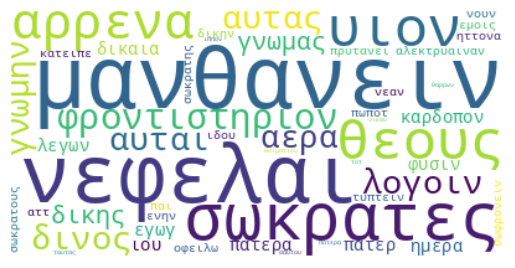

In [140]:
#Pseudocode 4. Create a word cloud based on the key words from *Clouds* (in comparison with the other plays). (cont.)

Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(clouds)

# Display the generated image
plt.imshow(Cloud, interpolation='bilinear')
plt.axis("off");

What to do next? The clearest next step for this exploration would be to compare the *Cloud* wordclouds to those for the other Aristophanic works. They are already in memory, ready to be generated. But it is worth asking then—what does it mean to compare one wordcloud to another? We should also check how the wordcloud change when you look at *Clouds* against a different set of reference texts, say, e.g., the plays of Euripides? all of Greek poetry? etc. This is the kind of read-write-refactor coding style that is at the heart of *Exploratory Philology*.

### References

::: {#refs}
:::